# Population loss in the immediate aftermath of a nuclear attack

In [9]:
# may be needed on Codespace to solve a weird problem with the way the venv is set up
# !pip uninstall basemap
# !pip install numpy==1.26.4

In [10]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src")
from main import Country, run_many_countries
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("https://raw.githubusercontent.com/allfed/ALLFED-matplotlib-style-sheet/main/ALLFED.mplstyle")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## (1) Single country
Use this to simulate an attack on a single country and visualize the results on an interactive map. For this demo we use the same targeting policy as Toon et al.

In [19]:
# country that is attacked
country_name = "United Kingdom" 

# nuclear arsenal with which the country is attacked (number of warheads and yield in kt)
arsenal = 200*[100] 

In [20]:
country = Country(country_name, landscan_year=2022, degrade=False, degrade_factor=1)

# sanity check - this corresponds to the population of the selected country
country.data.sum()

67044528

In [21]:
country.attack_max_fatality(arsenal, include_injuries=False, non_overlapping=True)

In [22]:
country.print_diagnostic_info()

Total fatalities: 18328999 (27.3%)
Total destroyed industrial area: 29.8%
Soot emissions: 5.4 Tg



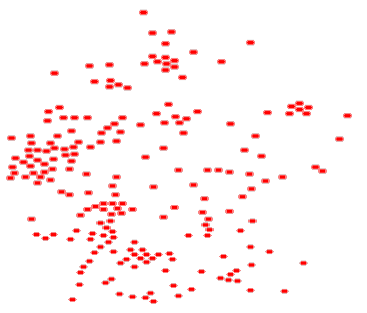

In [9]:
m = country.plot(show_hit_regions=True, show_industrial_areas=False, show_custom_locations=True)
m

## (2) Multiple countries
Once you're confident that everything works for a single country, you can also run the model for multiple countries.

In [ ]:
# This is the SORT scenario of Toon et al. 2008
scenario = {
    # "France": 200 * [100],
    # "United Kingdom": 200 * [100],
    "Germany": 200 * [100],
    # "India": 200 * [100],
    # "Pakistan": 200 * [100],
    # "Japan": 200 * [100],
    # "United States of America": 1000 * [100],
    # "China": 1100 * [100],
    # "Russia": 1100 * [100],
}

In [ ]:
run_many_countries(scenario, degrade=False, degrade_factor=3, targeting_policy="max_fatality_non_overlapping")

Let's plot the results

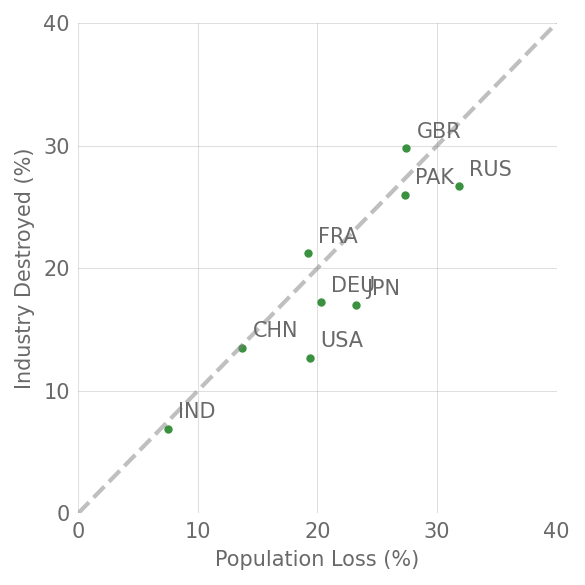

In [3]:
# Read the CSV file
df = pd.read_csv("../results/Toon2008_SORT_revised_burn_radius.csv")

# Create a square plot
fig, ax = plt.subplots(figsize=(4, 4))

# Create the scatter plot
scatter = ax.scatter(df["population_loss_pct"], df["industry_destroyed_pct"])

# Add labels for each point
for i, txt in enumerate(df["iso3"]):
    ax.annotate(
        txt,
        (df["population_loss_pct"][i], df["industry_destroyed_pct"][i]),
        xytext=(5, 5),
        textcoords="offset points",
    )

# Add labels and title
ax.set_xlabel("Population Loss (%)")
ax.set_ylabel("Industry Destroyed (%)")

# Add a diagonal line
max_value = 40
ax.plot([0, max_value], [0, max_value], "--", alpha=0.5, color="grey")
plt.xlim(0, 40)
plt.ylim(0, 40)

# gridline only every 10
ax.set_xticks(np.arange(0, 50, 10))
ax.set_yticks(np.arange(0, 50, 10))

# Display the plot
plt.tight_layout()
plt.show()

## (3) Impact of multiple hits with finite accuracy
Here's a more advanced use case. We want to know what's the difference in terms of fatalities if we target many weapons at the same spot (but with some uncertainty) vs using the same weapons to target different locations in the same city. For this we use higher-resolution data. We use NYC as an example.

In [ ]:
region = Country(
    country_name="United States of America",
    landscan_year=2021,
    degrade=False,
    use_HD=True,
    subregion=[-74.259090, -73.251740, 40.477399, 41.024100]
)
region_clean = copy.deepcopy(region)

In [ ]:
number_of_weapons = 1
yield_of_weapons = 15
CEP = 1000

**Case 1**: different targets, non-overlapping

In [ ]:
region = copy.deepcopy(region_clean)
region.attack_max_fatality(arsenal=number_of_weapons*[yield_of_weapons], include_injuries=False, non_overlapping=True)
print(region.get_total_fatalities())
print(region.target_list)
# m = region.plot(show_hit_regions=True)
# m

**Case 2**: different targets, overlapping allowed

In [ ]:
region = copy.deepcopy(region_clean)
region.attack_max_fatality(arsenal=number_of_weapons*[yield_of_weapons], include_injuries=False, non_overlapping=False)
print(region.get_total_fatalities())
# m = region.plot(show_hit_regions=True)
# m

**Case 3**: all weapons targeted at the same high-value target

In [ ]:
fatalities_list = []
for _ in range(10):
    region = copy.deepcopy(region_clean)
    for i in range(number_of_weapons):
        region.attack_specific_target(
            lat=40.74721112908017,
            lon=-73.98510350648793,
            yield_kt=yield_of_weapons,
            CEP=CEP,
        )
    fatalities_list.append(region.get_total_fatalities())

mean_fatalities = sum(fatalities_list) / len(fatalities_list)
confidence_interval = np.percentile(fatalities_list, [5, 95])
print("Mean Fatalities:", mean_fatalities)
print("90% Confidence Interval of Fatalities:", confidence_interval)
# m = region.plot(show_hit_regions=True)
# m


Fatalities in millions
| Weapons  | Max fatality (overlap forbidden) | Max fatality (overlap allowed) | Max value target (CEP = 200m) | Max value target (CEP = 1000m) |
|----------|----------|----------|----------|----------|
| 1 x 100kt| 2.37 | 2.37 | 2.36-2.37 | 2.11-2.36 |
| 2 x 100kt| 2.97 | 3.20 | 2.93-2.94 | 2.88-2.99 |
| 3 x 100kt| 3.54 | 3.89 | 3.22-3.26 | 3.18-3.34 |
| 4 x 100kt| 3.99 | 4.51 | 3.42-3.44 |3.39-3.55 |
| 1 x 15kt | 1.13 | 1.13 | 0.99-1.08 | 0.68-1.04 |
| 2 x 15kt | 1.46 | 1.60 | 1.37-1.42 | 0.90-1.34 |
| 3 x 15kt | 1.67 | 1.92 | 1.55-1.58| 1.29-1.66 |
| 4 x 15kt | 1.84  | 2.19 | 1.65-1.68  | 1.53-1.83 |


## (4) Using pre-defined nuclear war target lists

In [23]:
country_name = "Russia"
country = Country(country_name, landscan_year=2022, degrade=False, degrade_factor=3)
country.apply_1956_US_nuclear_war_plan(yield_kt=100)
country.print_diagnostic_info()

In [ ]:
country_name = "China"
country = Country(country_name, landscan_year=2022, degrade=False, degrade_factor=3)
country.apply_1956_US_nuclear_war_plan(yield_kt=100)
country.print_diagnostic_info()

In [ ]:
country_name = "United States of America"
country = Country(country_name, landscan_year=2022, degrade=False, degrade_factor=3)
country.apply_OPEN_RISOP_nuclear_war_plan(yield_kt=100)
country.print_diagnostic_info()

## (5) How the results scale with respect to number of weapons used for counter-value targeting

In [11]:
from main import build_scaling_curve, plot_scaling_results

In [12]:
build_scaling_curve(
    country_name="United Kingdom",
    yield_kt=100,
    # numbers_of_weapons=[int(x) for x in np.logspace(1, 3, 10)],
    numbers_of_weapons=[2000],
    non_overlapping=False,
    degrade_factor=1,
)

Number of weapons: 2000
Total fatalities: 56702477 (84.6%)
Total destroyed industrial area: 88.6%
Soot emissions: 38.4 Tg


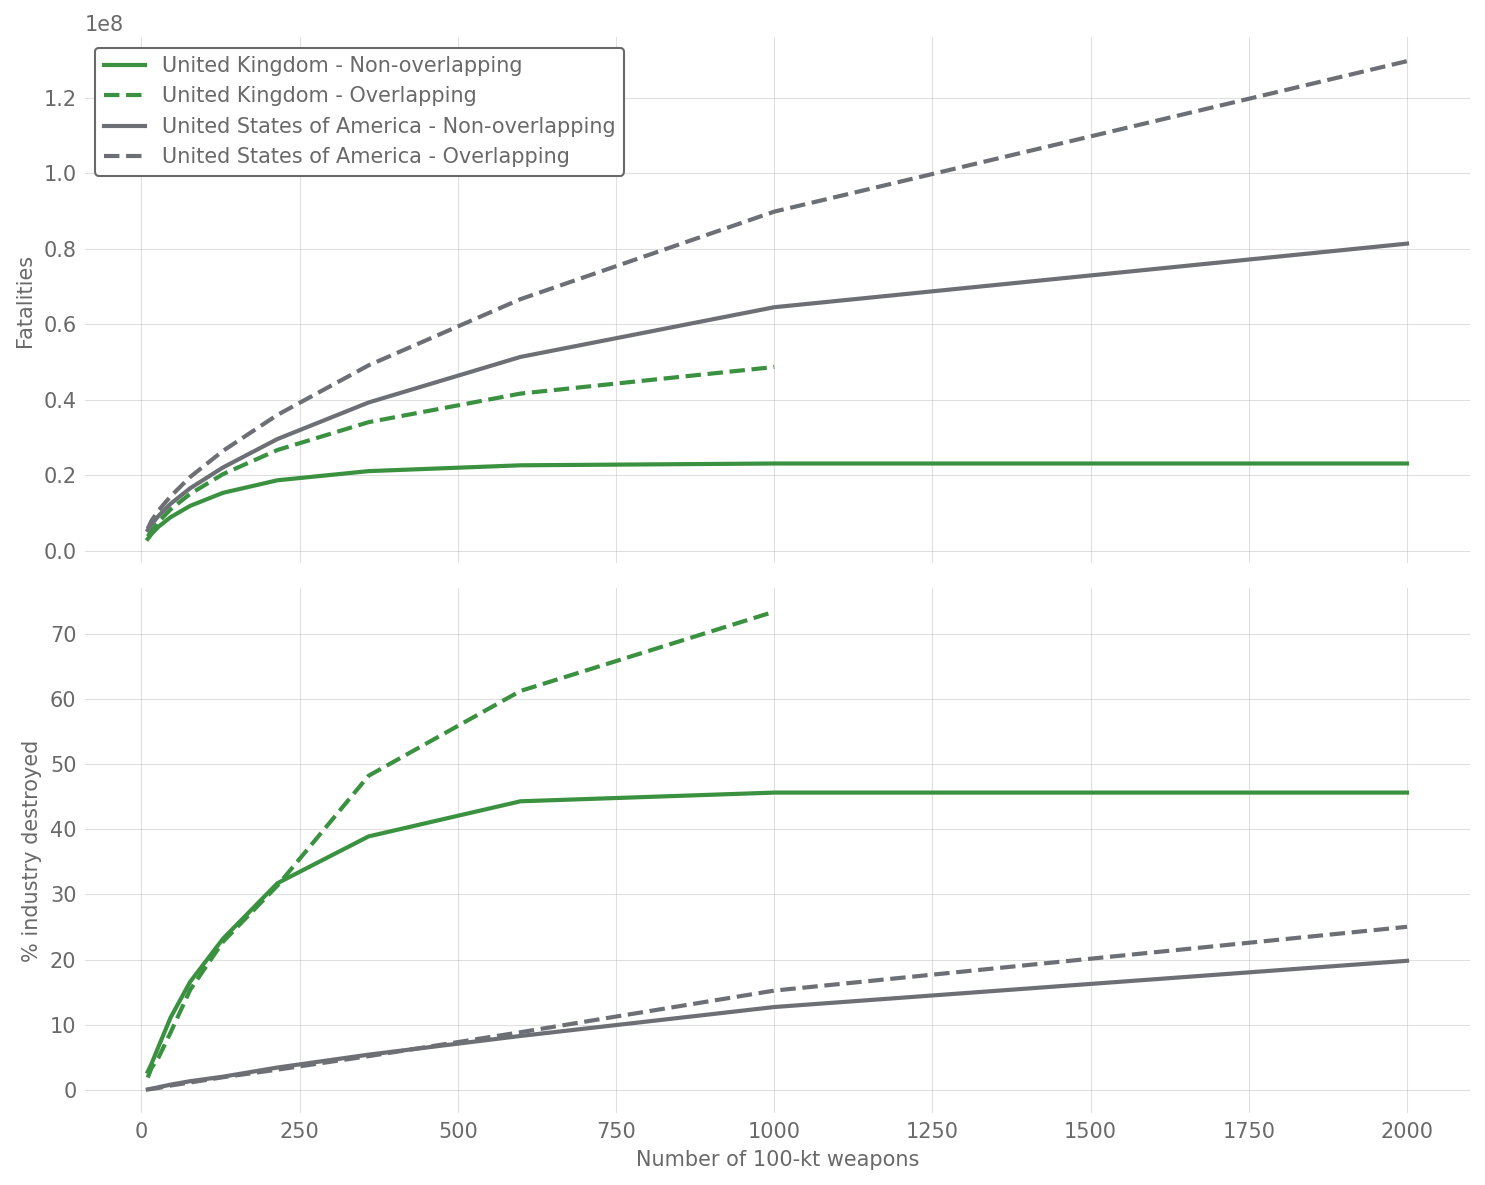

In [8]:
plot_scaling_results()